## Pneumonia Detection from Chest X-ray Images

In this notebook, a `Convolutional Neural Network (CNN)` has been developed and trained to select the presence of `pneumonia` disease by analyzing chest X-ray images.

This is a `binary classification` problem where the outcome is either a person has `pneumonia` disease or not (`normal` condition).

This model is built from scratch, i.e. not relying on transfer learning approaches (pre-trained models).

- Here we are applying no data augmentation
-  applying only 12 epochs

### Import Libraries

In [44]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

### Configurations

In [45]:
MODEL_LOC = 'model_best_pneumonia_detection_cnn_model.h5'
DATA_DIR = 'chest_xray/'
TRAINING_DATA_DIR = 'chest_xray/train/'
TEST_DATA_DIR = 'chest_xray/test/'
VAL_DATA_DIR = 'chest_xray/val/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
BATCH_SIZE = 32
EPOCHS = 12 # original was 100

timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
MODEL_FILE = f"model_{EPOCHS}_epochs_{timestamp}.h5"
print(MODEL_FILE)

model_12_epochs_2025-05-11-11-02.h5


### Exploratory Data Analysis (EDA)

In [46]:
def count_images(directory_name, detection_class):
    return len(os.listdir(os.path.join(directory_name, detection_class)))

# Prepare counts
data = [
    ['Dataset Type', 'Normal', 'Pneumonia'],
    ['Training', count_images(TRAINING_DATA_DIR, 'NORMAL'), count_images(TRAINING_DATA_DIR, 'PNEUMONIA')],
    ['Test', count_images(TEST_DATA_DIR, 'NORMAL'), count_images(TEST_DATA_DIR, 'PNEUMONIA')],
    ['Validation', count_images(VAL_DATA_DIR, 'NORMAL'), count_images(VAL_DATA_DIR, 'PNEUMONIA')],
]

# Print table
col_widths = [max(len(str(row[i])) for row in data) for i in range(3)]

for row in data:
    print(f"{str(row[0]).ljust(col_widths[0])} | {str(row[1]).rjust(col_widths[1])} | {str(row[2]).rjust(col_widths[2])}")


Dataset Type | Normal | Pneumonia
Training     |   1341 |      3875
Test         |    234 |       390
Validation   |      8 |         8


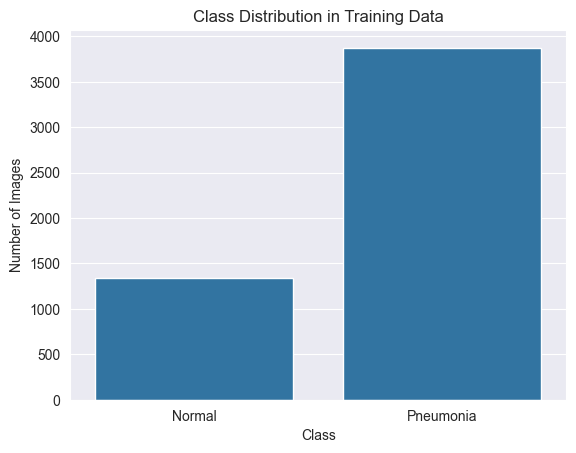

Normal: 1341
Pneumonia: 3875


In [47]:

# Count training images
normal_count    = count_images(TRAINING_DATA_DIR, 'NORMAL')
pneumonia_count = count_images(TRAINING_DATA_DIR, 'PNEUMONIA')

# Data for plotting
classes = ['Normal', 'Pneumonia']
counts = [normal_count, pneumonia_count]

# Plotting
sns.set_style('darkgrid')
sns.barplot(x=classes, y=counts)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Optional: Print counts
for cls, count in zip(classes, counts):
    print(f"{cls}: {count}")


As can be seen from the above data exploration, the data is highly imbalanced. That is, the number of images for `pneumonia` cases are much higher than the `normal` cases. However, this is expected in the medical data, as a person is advised to have the X-ray done if some symptoms are noticed and hence more likely to have the disease.

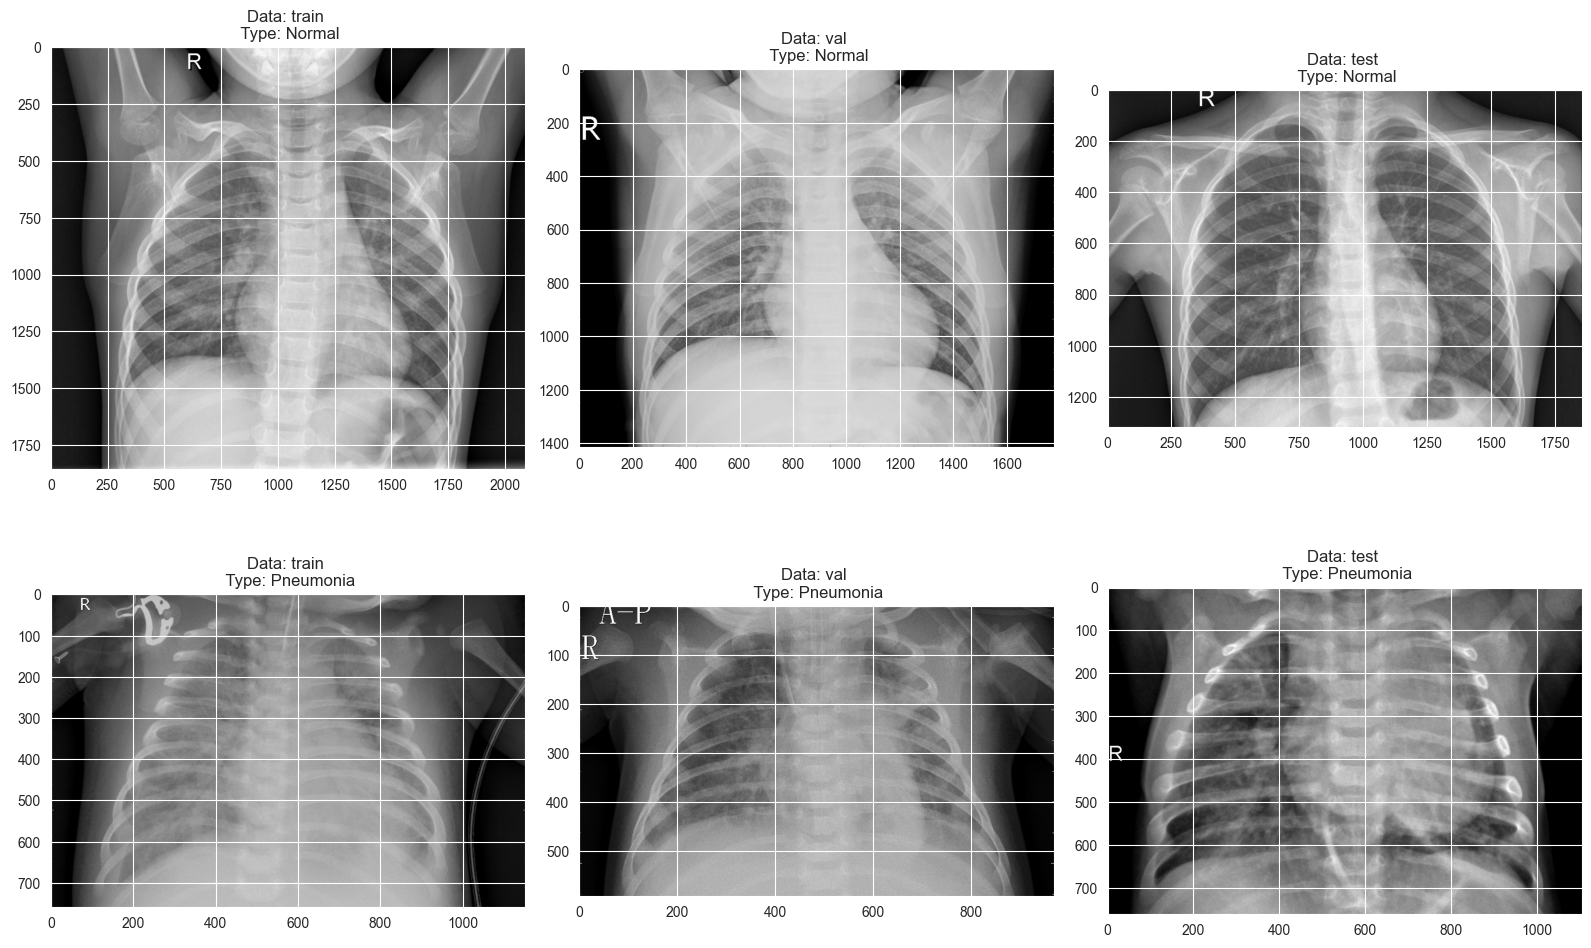

In [48]:
# Looking at one image per class in each dataset type
fig, ax = plt.subplots(2, 3, figsize = (16, 10))
ax = ax.ravel()
plt.tight_layout()

for i, subdir in enumerate(['train', 'val', 'test']):
    image_path = DATA_DIR + subdir
    ax[i].imshow(plt.imread(image_path + '/NORMAL/' + os.listdir(image_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(subdir), fontsize = 12)
    ax[i+3].imshow(plt.imread(image_path + '/PNEUMONIA/' + os.listdir(image_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(subdir), fontsize = 12)

### Prepare Data

In [49]:
# data generator on training dataset, no data augmentation
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the training dataset, no shuffle
training_dataset = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                     classes=DETECTION_CLASSES,
                                                     shuffle=False,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(224, 224))




# data generator on test dataset, data augmentation not applied
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset 
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                classes=DETECTION_CLASSES,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                target_size=(224, 224))




# data generator on validation dataset, data augmentation not applied
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
val_dataset = val_datagen.flow_from_directory(VAL_DATA_DIR,
                                              classes=DETECTION_CLASSES,
                                              shuffle=False,
                                              batch_size=BATCH_SIZE,
                                              target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [50]:
# printing the assigned indices for sanity check
print(f'class indices:  {training_dataset.class_indices}')

class indices:  {'NORMAL': 0, 'PNEUMONIA': 1}


### Build `CNN` Model

The following model consists of five `convolution` blocks where after each block, a pooling layer (`max pooling`) is added. The `flattening` layer after the last convolution block prepares the input to be fed into the fully connected layers. In each fully connected layer, `dense` method is used to add a hidden layer where `units` represent the number of nodes/neurons in that layer. The last fully connected layer has two nodes representing the two classes - `pneumonia` and `normal` where the `softmax` activation function (as the two cases are mutually exclusive case) is used. One can also use in this case the `sigmoid` activation function with one unit in the output layer with `binary cross-entropy` loss. 

In [51]:
cnn_model = Sequential()

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))

#  Display model
cnn_model.summary()

# compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_16                  │ (None, 112, 112, 32)        │             688 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_17                  │ (None, 112, 112, 32)        │           1,344 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_18                  │ (None, 56, 56, 64)          │           2,400 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_19                  │ (None, 56, 56, 64)          │           4,736 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_20                  │ (None, 28, 28, 128)         │           8,896 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_21                  │ (None, 28, 28, 128)         │          17,664 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_22                  │ (None, 14, 14, 256)         │          34,1

 Total params: 6,639,778 (25.33 MB)

 Trainable params: 6,638,818 (25.33 MB)

 Non-trainable params: 960 (3.75 KB)

### Train `CNN` Model


In [52]:
# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [53]:
# fit the model
# 12 epoch took 30 minutes on CPU

history = cnn_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=val_dataset,
                        validation_steps=len(val_dataset),
                        epochs=EPOCHS,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.6790 - loss: 0.7080  

163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 801ms/step - accuracy: 0.6793 - loss: 0.7078 - val_accuracy: 0.5000 - val_loss: 0.7169
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 830ms/step - accuracy: 0.6932 - loss: 0.6650 - val_accuracy: 0.5000 - val_loss: 0.8910
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.7467 - loss: 0.6345  

163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 813ms/step - accuracy: 0.7466 - loss: 0.6347 - val_accuracy: 0.5000 - val_loss: 0.7100
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 784ms/step - accuracy: 0.7326 - loss: 0.6172 - val_accuracy: 0.5000 - val_loss: 0.7352
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 773ms/step - accuracy: 0.7458 - loss: 0.5816 - val_accuracy: 0.5000 - val_loss: 0.7700
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - accuracy: 0.7138 - loss: 0.6101 - val_accuracy: 0.5000 - val_loss: 0.8002
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 813ms/step - accuracy: 0.7532 - loss: 0.5661 - val_accuracy: 0.5000 - val_loss: 0.7777
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 805ms/step - accuracy: 0.7110 - loss: 0.6075 - val_accuracy: 0.5000 - val_loss: 0.8355
Epoch 9/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 808ms/step - accuracy: 0.7484 - loss: 0.5695 - val_accuracy: 0.5000 - val_loss: 0.9092
Epoch 10/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 865ms/step - accuracy: 0.7232 - loss: 0.6

# Note

In [54]:
# save the model
cnn_model.save(MODEL_FILE)  # creates a file 'model_20_epochs_time_stamp.h5' at the end

### Plot Training History

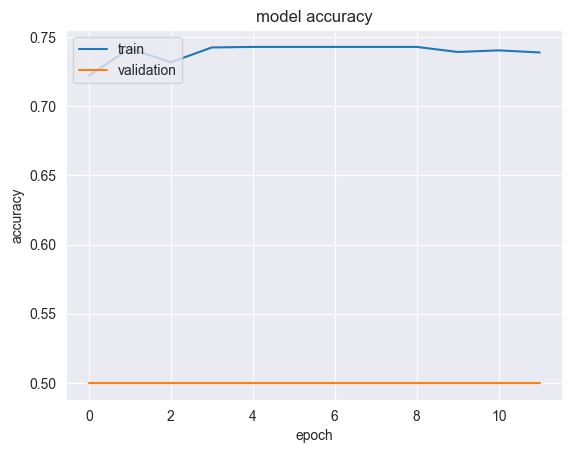

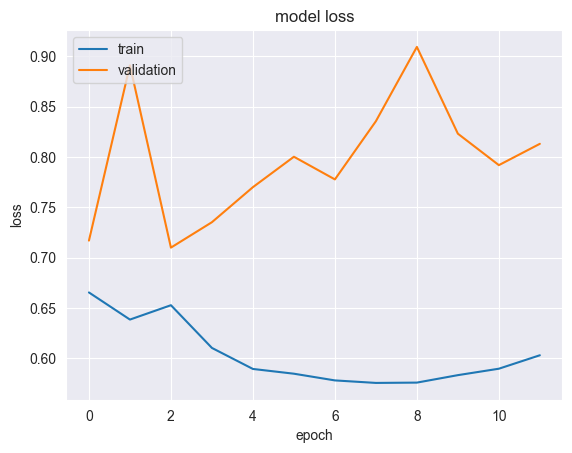

In [55]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Evaluation

### on test dataset

In [56]:
# load the trained CNN model
# cnn_model = load_model(MODEL_FILE) or  cnn_model = load_model(MODEL_LOC)

In [57]:
# storing the true classes of the test dataset
y_true = test_dataset.classes

# predicting the classes of the test dataset
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)

# Storing the predicted probability
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions
y_pred_binary = y_pred_prob > 0.5

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step 


In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
classification_report, roc_auc_score, roc_curve


Confusion Matrix for Test Dataset
 -------------------------
[[  0 234]
 [  0 390]]
############################


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

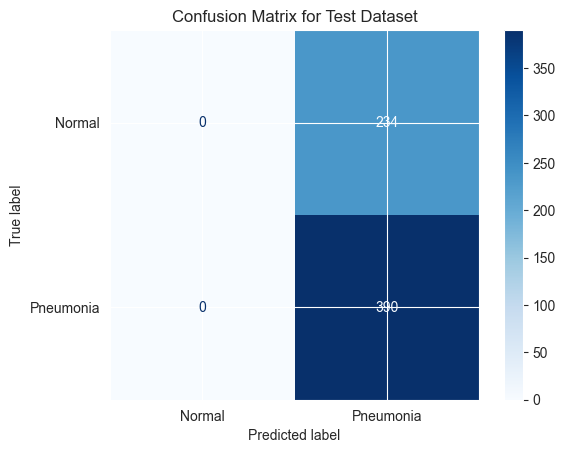

In [67]:
# confusion matrix for test dataset 
print('\nConfusion Matrix for Test Dataset\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)
print("############################")
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

# observation
All images are predicted as pneumonia. Now we will fix this in later notebooks.
- note that the input train  data was not shuffled. The initial data was all pneumonia, later followed by all Normal. Thats a BIG problem

In [61]:
# classification report
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1_score: 2 tp / (2 tp + fp + fn)
print('\nClassification Report\n -------------------------')
print(classification_report(y_true, y_pred_binary))


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [62]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC (Test Dataset) {auc:.2}')


ROC AUC (Test Dataset) 0.5


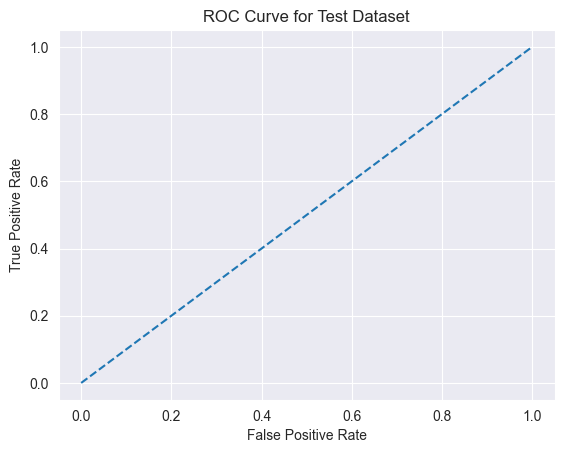

In [63]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.show()

# observation
Following is the stats I obtained when I ran for 12:

**1) Stats on 12 epochs**

```
Confusion Matrix for Test Dataset
 -------------------------
[[  0 234]
 [  0 390]]

Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

---------------

ROC AUC (Test Dataset) 0.5
```


### on validation dataset

In [64]:
# storing the true classes of the test dataset
y_true_val = val_dataset.classes

# predicting the classes of the test dataset
y_pred_val = cnn_model.predict(val_dataset, steps=len(val_dataset), verbose=1)

# Storing the predicted probability
y_pred_val_prob = y_pred_val[:, 1]

# Storing the binary classes for the predictions
y_pred_val_binary = y_pred_val_prob > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step



Confusion Matrix for Validation Dataset
 -------------------------
[[0 8]
 [0 8]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Dataset')

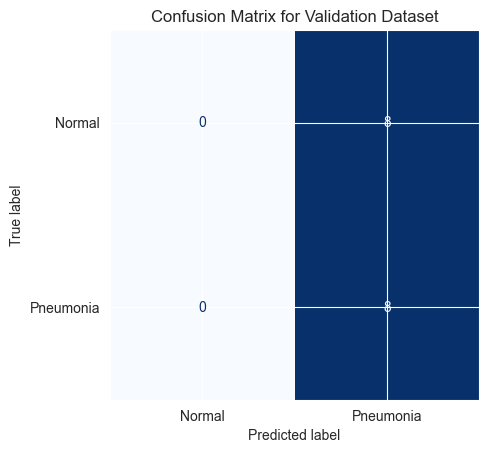

In [65]:
# confusion matrix for validation dataset 
print('\nConfusion Matrix for Validation Dataset\n -------------------------')
cm_val = confusion_matrix(y_true_val, y_pred_val_binary)
print(cm_val)

cm_display_val = ConfusionMatrixDisplay(cm_val, display_labels=['Normal', 'Pneumonia'])
cm_display_val.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Validation Dataset')